## Uploading Local or Google Drive Files to Use
This step allows the upload of local or Google Drive files to the cloud VM.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [0]:
# unzip the zip file and its contents should now be in /darknet/data/obj
%%capture
!unzip /mydrive/customYOLOv3.zip -d /mydrive/

## Building Darknet
We have adjusted the Makefile to enable OPENCV and GPU for darknet and then build darknet.

In [0]:
%%capture
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
# make darknet (build)
!make

In [6]:
!./darknet

usage: ./darknet <function>


In [7]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

--2020-04-13 12:07:48--  http://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/darknet53.conv.74 [following]
--2020-04-13 12:07:48--  https://pjreddie.com/media/files/darknet53.conv.74
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M   465KB/s    in 5m 59s  

2020-04-13 12:13:48 (442 KB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



## Adjusting Files to YOLOv3 Format

We need to save data in the proper location as well as edit the configuration files properly in order to go to the training step.

*YOLO cfg* file needs to be downloaded and the text of the three output layers is edited according to the number of classes in the problem. Moreover, the batch size as well as the number of iterations are adjusted.

+ General Configuration:

$maxbatches = 4000$

$steps = 3200, 3600$

**TRAINING**

$ batch = 64$

$subdivisions = 64$

**TEST**

$ batch = 1$

$subdivisions = 1$

+ 3 Last CONV+YOLO layers:

$classes = 1$

$filters = 3(n+5) = 3(1+5) = 18$


In [8]:
!cp /mydrive/customYOLOv3/classes.names ./data
!cat ./data/classes.names

cigarette


In [9]:
!cp /mydrive/customYOLOv3/labelled_data.data ./data
!cat ./data/labelled_data.data

classes = 1
train = data/train.txt
valid = data/validation.txt
names = data/classes.names
backup = /mydrive/customYOLOv3/backup

In [0]:
!cp /mydrive/customYOLOv3/train.txt ./data

In [0]:
!cp /mydrive/customYOLOv3/validation.txt ./data

## Training Custom YOLOv3

The main goal is the identification of cigarettes.

In [12]:
%%time
%%capture
!./darknet detector train data/labelled_data.data cfg/yolov3_train.cfg /mydrive/customYOLOv3/backup/yolov3_train_last.weights -dont_show

CPU times: user 46.6 s, sys: 8.34 s, total: 55 s
Wall time: 6h 26min 22s


**TIP:** This training could take several hours depending on how many iterations you chose in the .cfg file. You will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it's VMs if you are idle for too long (30-90 mins).

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit **Enter**
```
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)
```


## Loss during training

We can observe how the loss function behaves according to the number os iterations.

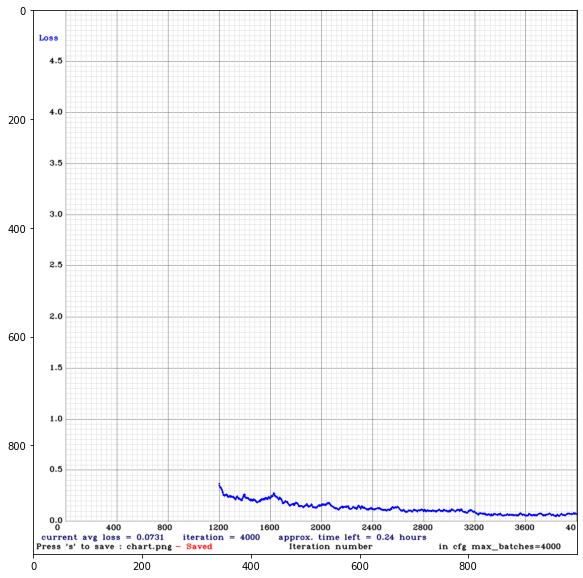

In [13]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

img = cv2.cvtColor(cv2.imread("chart.png"), cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.imshow(img)
plt.show()

## Evaluating Weights

In order to avoid overfitting and underfitting, it is necessary to evaluate mAP (mean average precision) provided by each configuration.

It is the mean value for the area under precision-recall curve.

In [14]:
!./darknet detector map data/labelled_data.data cfg/yolov3_train.cfg /mydrive/customYOLOv3/backup/yolov3_train_final.weights

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 compute_capability = 600, cudnn_half = 0 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2    304 x 304 x  64 ->  152 x 152 x 128 3.407 BF
   6 conv     64       1 x 1/ 1    152 x 152 x 128 ->  152 x 152 x  64 0.379 BF
   7 conv    128       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 152 x 152 x 128 0.003 BF
   9 conv     64

As we can conclude from results displayed above, our best weights file is the one saved at last iteration.

Therefore, this is the file which we download.

## Testing Our Model

We are going to test our model with a new image.

In [18]:
!./darknet detector test data/labelled_data.data cfg/yolov3_test.cfg /mydrive/customYOLOv3/backup/yolov3_train_last.weights /mydrive/customYOLOv3/test/cigarette.jpg -thresh 0.3

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 compute_capability = 600, cudnn_half = 0 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2    304 x 304 x  64 ->  152 x 152 x 128 3.407 BF
   6 conv     64       1 x 1/ 1    152 x 152 x 128 ->  152 x 152 x  64 0.379 BF
   7 conv    128       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 152 x 152 x 128 0.003 BF
   9 conv     64 

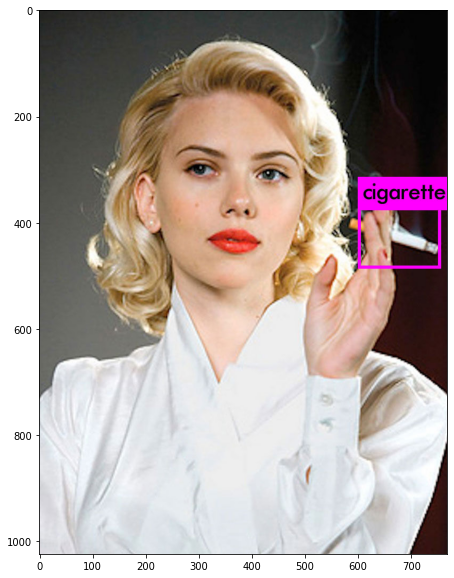

In [19]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

img = cv2.cvtColor(cv2.imread("predictions.jpg"), cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.imshow(img)
plt.show()